# 04. LightGBM with Optuna Optimization

This notebook trains a LightGBM model using Optuna for hyperparameter optimization. It uses a validation set for tuning and refits the best model on Train+Val before final evaluation on Test.

In [1]:
# Imports
import pandas as pd
import numpy as np
import pickle
import json
import os
import matplotlib.pyplot as plt
import lightgbm as lgb
import optuna
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve, 
    precision_recall_curve, auc, brier_score_loss,
    confusion_matrix, classification_report
)
import warnings
warnings.filterwarnings("ignore")


# Settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
optuna.logging.set_verbosity(optuna.logging.WARNING)

## 1. Load Processed Data

In [2]:
# Load data
with open('../data/processed/churn_data.pkl', 'rb') as f:
    data = pickle.load(f)

# Use scaled data
X_train = data['X_train_scaled'] 
y_train = data['y_train']
X_val = data['X_val_scaled']
y_val = data['y_val']
X_test = data['X_test_scaled']
y_test = data['y_test']

print(f"Train samples: {len(X_train)}")
print(f"Val samples:   {len(X_val)}")
print(f"Test samples:  {len(X_test)}")

Train samples: 265
Val samples:   67
Test samples:  83


## 2. Optuna Optimization
Optuna is an automatic hyperparameter optimization software framework, particularly designed for machine learning. It features an define-by-run API that allows users to construct the search space dynamically.

Key concepts in Optuna:
- **Study**: Optimization based on an objective function.
- **Trial**: A single execution of the objective function.
- **Objective Function**: A function that takes a set of hyperparameters and returns a score (e.g., accuracy, loss) to be minimized or maximized.
- **Sampler**: The strategy used to sample parameters (e.g., TPE, Random Search).
- **Pruner**: A mechanism to stop unpromising trials early.

In this section, we will use Optuna to find the best hyperparameters for our LightGBM model by maximizing the ROC AUC score.

In [3]:
# Define objective function
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 15, 63),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'class_weight': 'balanced',
        'random_state': 42,
        'verbose': -1
    }
    
    # Fit on TRAIN, evaluate on VAL
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:, 1]
    
    return roc_auc_score(y_val, preds)

print("Starting Optuna optimization (50 trials)...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print(f"Best validation AUC: {study.best_value:.4f}")
print(f"Best parameters: {study.best_params}")

Starting Optuna optimization (50 trials)...


  0%|          | 0/50 [00:00<?, ?it/s]

Best validation AUC: 0.7256
Best parameters: {'n_estimators': 167, 'max_depth': 9, 'learning_rate': 0.02407662010394872, 'num_leaves': 42, 'min_child_samples': 40, 'subsample': 0.8347772125748354, 'colsample_bytree': 0.8972049250059488, 'reg_alpha': 9.968811508901407, 'reg_lambda': 4.955895447800657}


## 3. Retrain and Evaluate Best Model

In [4]:
# Refit on TRAIN + VAL
best_params = study.best_params
best_params['class_weight'] = 'balanced'
best_params['random_state'] = 42
best_params['verbose'] = -1

# Combine train and validation sets
X_train_full = np.concatenate([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

print(f"Retraining on full training set ({len(X_train_full)} samples)...")
best_lgb = lgb.LGBMClassifier(**best_params)
best_lgb.fit(X_train_full, y_train_full)

# Final predictions on TEST
lgb_pred_proba = best_lgb.predict_proba(X_test)[:, 1]
lgb_pred = (lgb_pred_proba >= 0.5).astype(int)

print(" Model retrained and evaluated")

Retraining on full training set (332 samples)...
 Model retrained and evaluated


## 4. Final Evaluation

In [5]:
# Metrics
accuracy = accuracy_score(y_test, lgb_pred)
roc_auc = roc_auc_score(y_test, lgb_pred_proba)

precision, recall, _ = precision_recall_curve(y_test, lgb_pred_proba)
pr_auc = auc(recall, precision)

brier = brier_score_loss(y_test, lgb_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"Brier Score: {brier:.4f}")

Accuracy: 0.7229
ROC-AUC: 0.7921
PR-AUC: 0.8355
Brier Score: 0.1955


 Saved optimization history plot


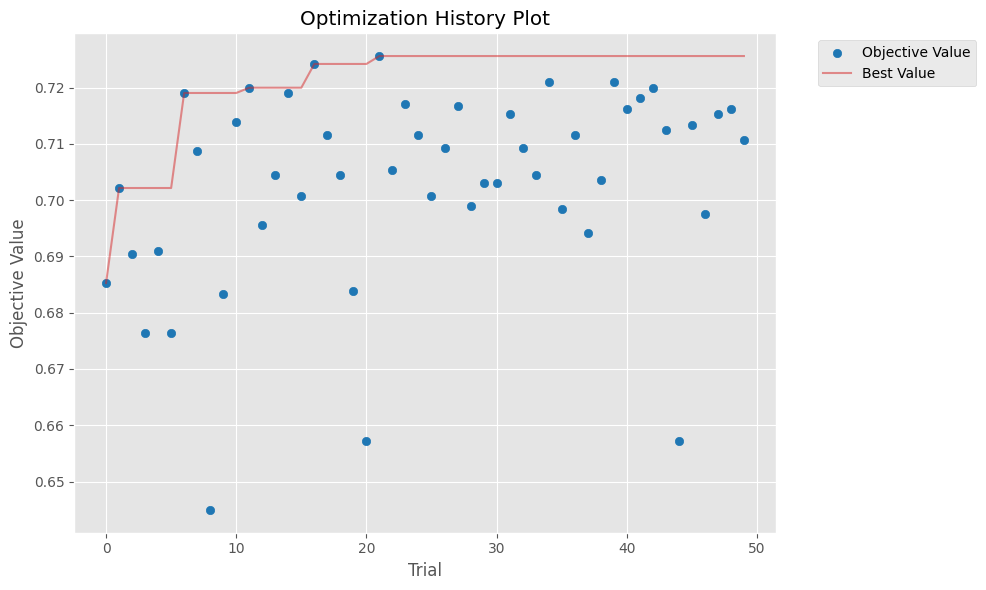

In [6]:
# Optimization History
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.tight_layout()

plt.savefig('../results/figures/lightgbm/lgbm_optimization_history.png')
print(' Saved optimization history plot')
plt.show()

## 5. Save Results

In [7]:
# Save Model
with open('../results/models/lightgbm/lightgbm.pkl', 'wb') as f:
    pickle.dump(best_lgb, f)
print(" Model saved to ../results/models/lightgbm/lightgbm.pkl")

# Save Metrics
metrics = {
    'model': 'LightGBM',
    'accuracy': accuracy,
    'roc_auc': roc_auc,
    'pr_auc': pr_auc,
    'brier': brier,
    'best_params': study.best_params
}

with open('../results/metrics/lightgbm/lightgbm.json', 'w') as f:
    json.dump(metrics, f, indent=4)
print(" Metrics saved to ../results/metrics/lightgbm/lightgbm.json")

 Model saved to ../results/models/lightgbm/lightgbm.pkl
 Metrics saved to ../results/metrics/lightgbm/lightgbm.json


In [8]:
#